In [1]:
import shap
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import plot_roc_curve, classification_report

/home/mfkn/.local/share/virtualenvs/Predict-Customer-Churn-with-Clean-Code-RT1TBCSI/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
os.environ['QT_QPA_PLATFORM']='offscreen'

In [3]:
df = pd.read_csv(r"./data/BankChurners.csv")
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [4]:
df.shape

(10127, 23)

In [5]:
df.isnull().sum()

CLIENTNUM                                                                                                                             0
Attrition_Flag                                                                                                                        0
Customer_Age                                                                                                                          0
Gender                                                                                                                                0
Dependent_count                                                                                                                       0
Education_Level                                                                                                                       0
Marital_Status                                                                                                                        0
Income_Category                                 

In [6]:
df = df.rename(columns={
    'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1' : 'Naive_Bayes_mon_1',
    'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2' : 'Naive_Bayes_mon_2'
})

In [7]:
cat_columns = [
    'Gender',
    'Education_Level',
    'Marital_Status',
    'Income_Category',
    'Card_Category'                
]

quant_columns = [
    'Customer_Age',
    'Dependent_count', 
    'Months_on_book',
    'Total_Relationship_Count', 
    'Months_Inactive_12_mon',
    'Contacts_Count_12_mon', 
    'Credit_Limit', 
    'Total_Revolving_Bal',
    'Avg_Open_To_Buy', 
    'Total_Amt_Chng_Q4_Q1', 
    'Total_Trans_Amt',
    'Total_Trans_Ct', 
    'Total_Ct_Chng_Q4_Q1', 
    'Avg_Utilization_Ratio'
]

In [8]:
df['Churn'] = df['Attrition_Flag'].apply(lambda val: 0 if val == "Existing Customer" else 1)

<BarContainer object of 2 artists>

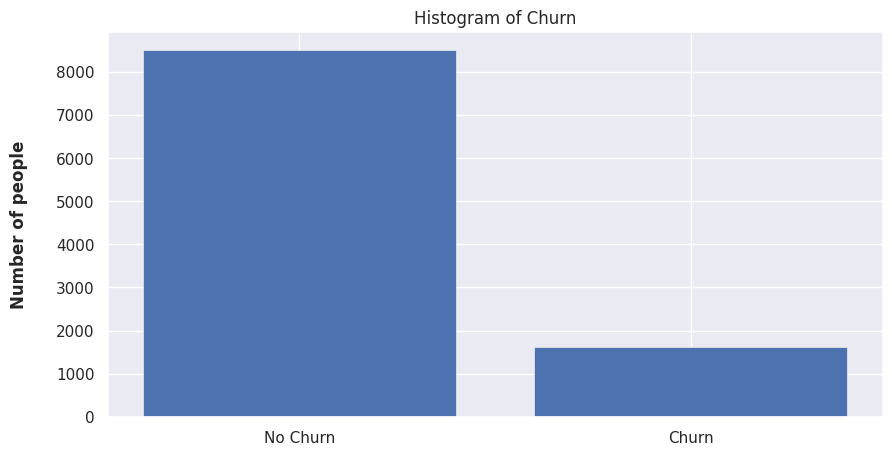

In [9]:
plt.figure(figsize=(10,5))
plt.title('Histogram of Churn')
#plt.suptitle('Churn Categorical Plotting')

plt.style.use('ggplot')
plt.locator_params(axis='y', integer=True)
plt.ylabel('Number of people', fontweight='bold', labelpad=20)

labels, counts = np.unique(df['Churn'], return_counts=True)
labels = ['No Churn', 'Churn']
plt.bar(labels, counts)
#plt.ylabel('Number of people', labelpad=20)

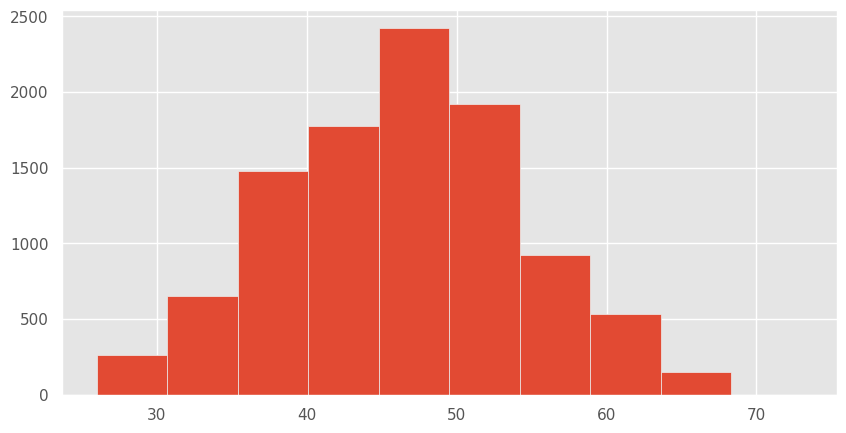

In [10]:
plt.figure(figsize=(10,5)) 
df['Customer_Age'].hist();

In [11]:
fig = plt.figure(figsize=(20,10)) 
labels, counts = np.unique(df.Marital_Status.value_counts('normalize'),  return_counts=True)
print(labels)
print(counts)
marital_status = df.Marital_Status.value_counts('normalize')

[0.07386195 0.0739607  0.38935519 0.46282216]
[1 1 1 1]


<Figure size 2000x1000 with 0 Axes>

In [12]:
marital_status.index

Index(['Married', 'Single', 'Unknown', 'Divorced'], dtype='object')

In [13]:
marital_status.values


array([0.46282216, 0.38935519, 0.0739607 , 0.07386195])

In [14]:
marital_status.sort_values(ascending=False)

Married     0.462822
Single      0.389355
Unknown     0.073961
Divorced    0.073862
Name: Marital_Status, dtype: float64

<AxesSubplot: title={'center': 'Histogram Normalised of Marital Status'}, ylabel='Normalised Frequency'>

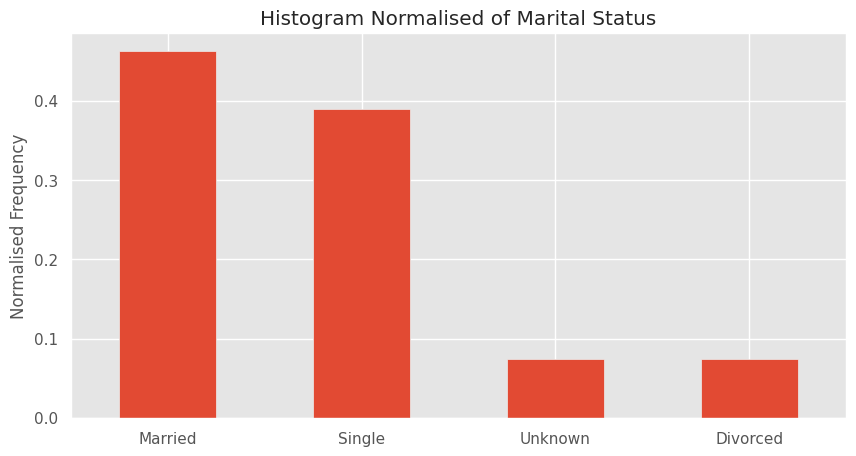

In [15]:
df.Marital_Status.value_counts('normalize').sort_values(ascending=False).plot.bar(figsize=(10,5),title="Histogram Normalised of Marital Status", ylabel= "Normalised Frequency", rot=0)

In [16]:
fig.get_axes()

[]

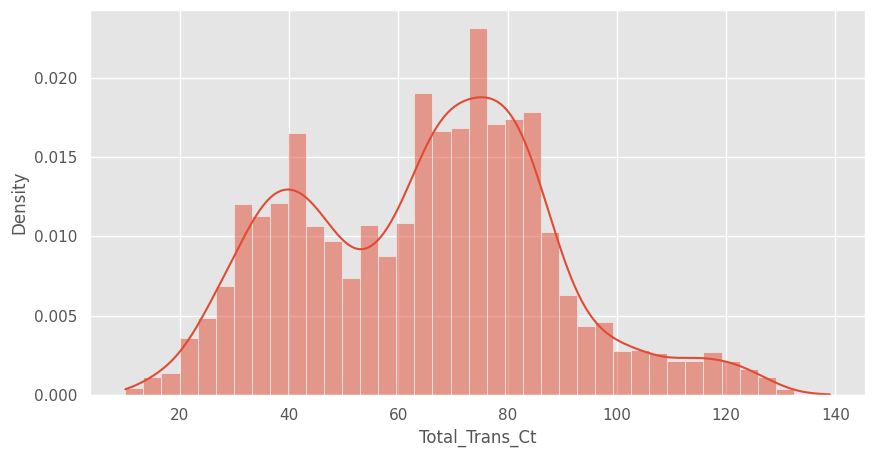

In [17]:
plt.figure(figsize=(10,5)) 
# distplot is deprecated. Use histplot instead
# sns.distplot(df['Total_Trans_Ct']);
# Show distributions of 'Total_Trans_Ct' and add a smooth curve obtained using a kernel density estimate
sns.histplot(df['Total_Trans_Ct'], stat='density', kde=True);

In [18]:
plt.figure(figsize=(10,5)) 
ax = fig.add_subplot(111)
ax.tick_params(top=True, bottom=False)
ax.tick_params(labeltop=True, labelbottom=False)

sns.heatmap(df.corr(), annot=False, cmap='Dark2_r', linewidths = 2, ax=ax)
plt.show()


The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


<Figure size 1000x500 with 0 Axes>

In [19]:
y = df['Churn']

In [20]:
X = pd.DataFrame()

In [21]:
# gender encoded column
gender_lst = []
gender_groups = df.groupby('Gender').mean()['Churn']

for val in df['Gender']:
    gender_lst.append(gender_groups.loc[val])

df['Gender_Churn'] = gender_lst  
#education encoded column
edu_lst = []
edu_groups = df.groupby('Education_Level').mean()['Churn']

for val in df['Education_Level']:
    edu_lst.append(edu_groups.loc[val])

df['Education_Level_Churn'] = edu_lst

#marital encoded column
marital_lst = []
marital_groups = df.groupby('Marital_Status').mean()['Churn']

for val in df['Marital_Status']:
    marital_lst.append(marital_groups.loc[val])

df['Marital_Status_Churn'] = marital_lst

#income encoded column
income_lst = []
income_groups = df.groupby('Income_Category').mean()['Churn']

for val in df['Income_Category']:
    income_lst.append(income_groups.loc[val])

df['Income_Category_Churn'] = income_lst

#card encoded column
card_lst = []
card_groups = df.groupby('Card_Category').mean()['Churn']
 
for val in df['Card_Category']:
    card_lst.append(card_groups.loc[val])

df['Card_Category_Churn'] = card_lst
    
    

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will

In [22]:
keep_cols = ['Customer_Age', 'Dependent_count', 'Months_on_book',
             'Total_Relationship_Count', 'Months_Inactive_12_mon',
             'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
             'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
             'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
             'Gender_Churn', 'Education_Level_Churn', 'Marital_Status_Churn', 
             'Income_Category_Churn', 'Card_Category_Churn']

X[keep_cols] = df[keep_cols]

In [23]:
X.head()

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Gender_Churn,Education_Level_Churn,Marital_Status_Churn,Income_Category_Churn,Card_Category_Churn
0,45,3,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.146152,0.152012,0.151269,0.134807,0.160979
1,49,5,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.173572,0.155691,0.169414,0.171862,0.160979
2,51,3,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.146152,0.155691,0.151269,0.157655,0.160979
3,40,4,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.173572,0.152012,0.172230,0.171862,0.160979
4,40,3,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.146152,0.159381,0.151269,0.134807,0.160979


In [24]:
# This cell may take up to 15-20 minutes to run
# train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state=42)

# grid search
rfc = RandomForestClassifier(random_state=42)
# Use a different solver if the default 'lbfgs' fails to converge
# Reference: https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lrc = LogisticRegression(solver='lbfgs', max_iter=3000)

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt'],
    'max_depth' : [4,5,100],
    'criterion' :['gini', 'entropy']
}

cv_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)
cv_rfc.fit(X_train, y_train)

lrc.fit(X_train, y_train)

y_train_preds_rf = cv_rfc.best_estimator_.predict(X_train)
y_test_preds_rf = cv_rfc.best_estimator_.predict(X_test)

y_train_preds_lr = lrc.predict(X_train)
y_test_preds_lr = lrc.predict(X_test)


In [25]:

# scores
print('random forest results')
print('test results')
class_report = classification_report(y_test, y_test_preds_rf,output_dict = True)
print(class_report)
print('train results')
print(classification_report(y_train, y_train_preds_rf))

print('logistic regression results')
print('test results')
print(classification_report(y_test, y_test_preds_lr))
print('train results')
print(classification_report(y_train, y_train_preds_lr))

random forest results
test results
{'0': {'precision': 0.9628637059724349, 'recall': 0.988989382618954, 'f1-score': 0.9757516973811834, 'support': 2543}, '1': {'precision': 0.9344262295081968, 'recall': 0.8044354838709677, 'f1-score': 0.8645720476706392, 'support': 496}, 'accuracy': 0.9588680487002303, 'macro avg': {'precision': 0.9486449677403158, 'recall': 0.8967124332449609, 'f1-score': 0.9201618725259113, 'support': 3039}, 'weighted avg': {'precision': 0.9582223804290777, 'recall': 0.9588680487002303, 'f1-score': 0.9576058907815026, 'support': 3039}}
train results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5957
           1       1.00      1.00      1.00      1131

    accuracy                           1.00      7088
   macro avg       1.00      1.00      1.00      7088
weighted avg       1.00      1.00      1.00      7088

logistic regression results
test results
              precision    recall  f1-score   support

  

In [26]:
for k,v in class_report.items():
    print(f"\n{k}: {v}")


0: {'precision': 0.9628637059724349, 'recall': 0.988989382618954, 'f1-score': 0.9757516973811834, 'support': 2543}

1: {'precision': 0.9344262295081968, 'recall': 0.8044354838709677, 'f1-score': 0.8645720476706392, 'support': 496}

accuracy: 0.9588680487002303

macro avg: {'precision': 0.9486449677403158, 'recall': 0.8967124332449609, 'f1-score': 0.9201618725259113, 'support': 3039}

weighted avg: {'precision': 0.9582223804290777, 'recall': 0.9588680487002303, 'f1-score': 0.9576058907815026, 'support': 3039}


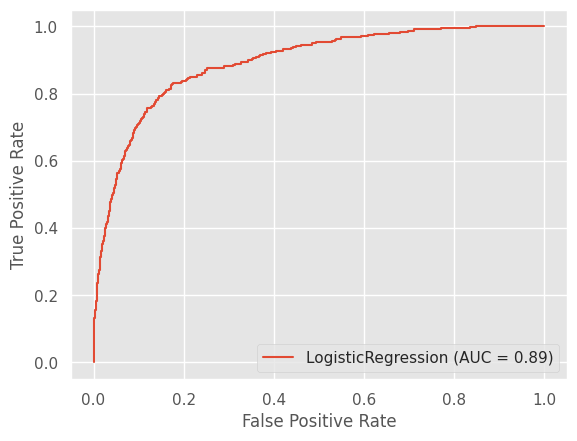

In [27]:
lrc_plot = plot_roc_curve(lrc, X_test, y_test)

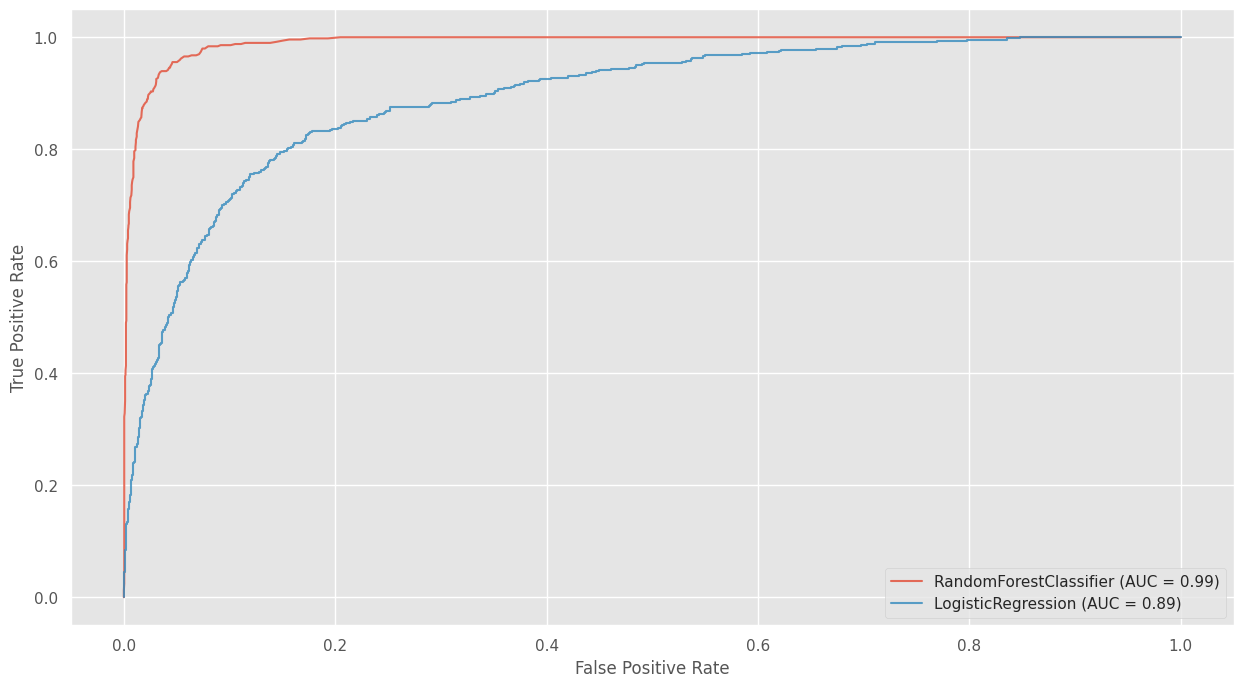

In [28]:
# plots
plt.figure(figsize=(15, 8))
ax = plt.gca()
rfc_disp = plot_roc_curve(cv_rfc.best_estimator_, X_test, y_test, ax=ax, alpha=0.8)
lrc_plot.plot(ax=ax, alpha=0.8)
plt.show()

In [29]:
# save best model
joblib.dump(cv_rfc.best_estimator_, './models/rfc_model.pkl')
joblib.dump(lrc, './models/logistic_model.pkl')

['./models/logistic_model.pkl']

In [30]:
rfc_model = joblib.load('./models/rfc_model.pkl')
lr_model = joblib.load('./models/logistic_model.pkl')

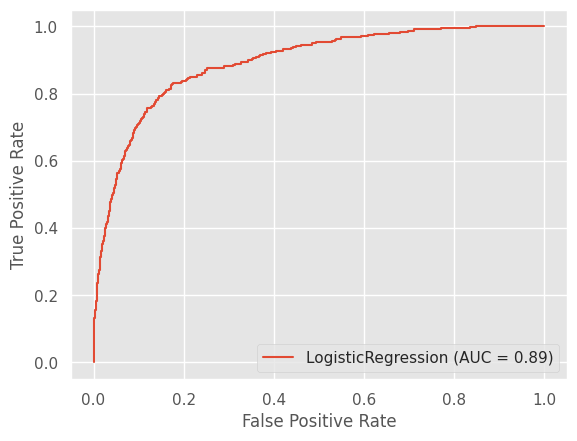

In [31]:
lrc_plot = plot_roc_curve(lr_model, X_test, y_test)

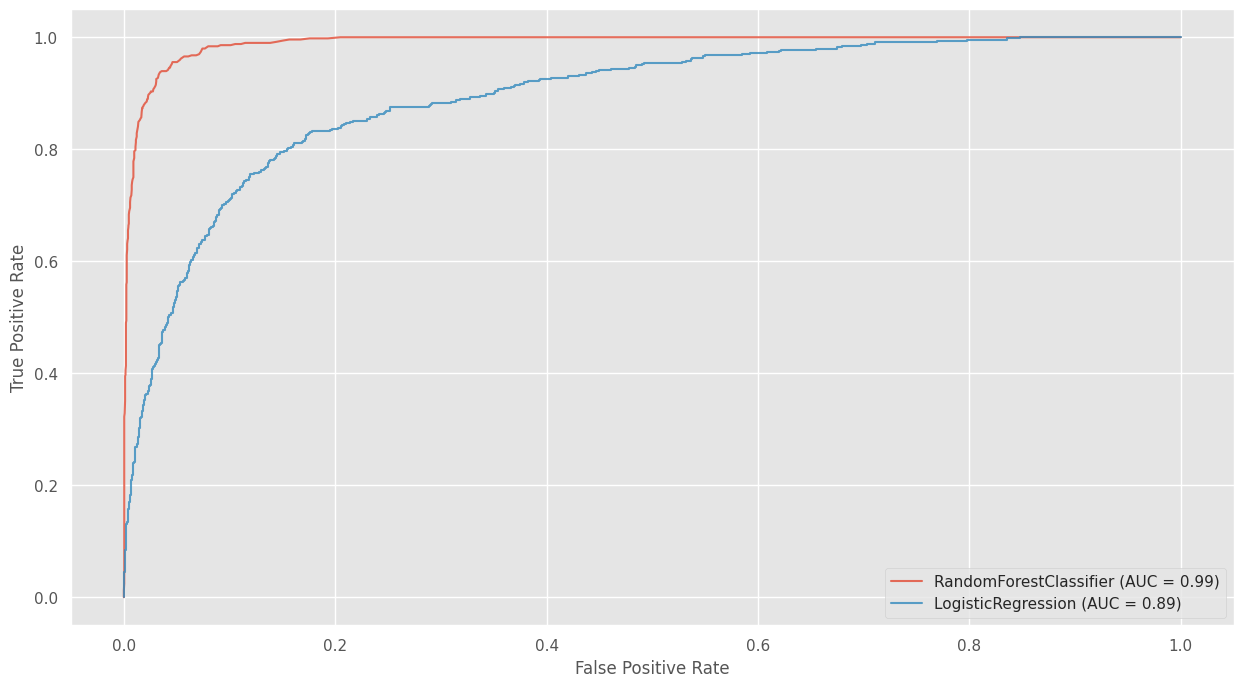

In [32]:
plt.figure(figsize=(15, 8))
ax = plt.gca()
rfc_disp = plot_roc_curve(rfc_model, X_test, y_test, ax=ax, alpha=0.8)
lrc_plot.plot(ax=ax, alpha=0.8)
plt.show()

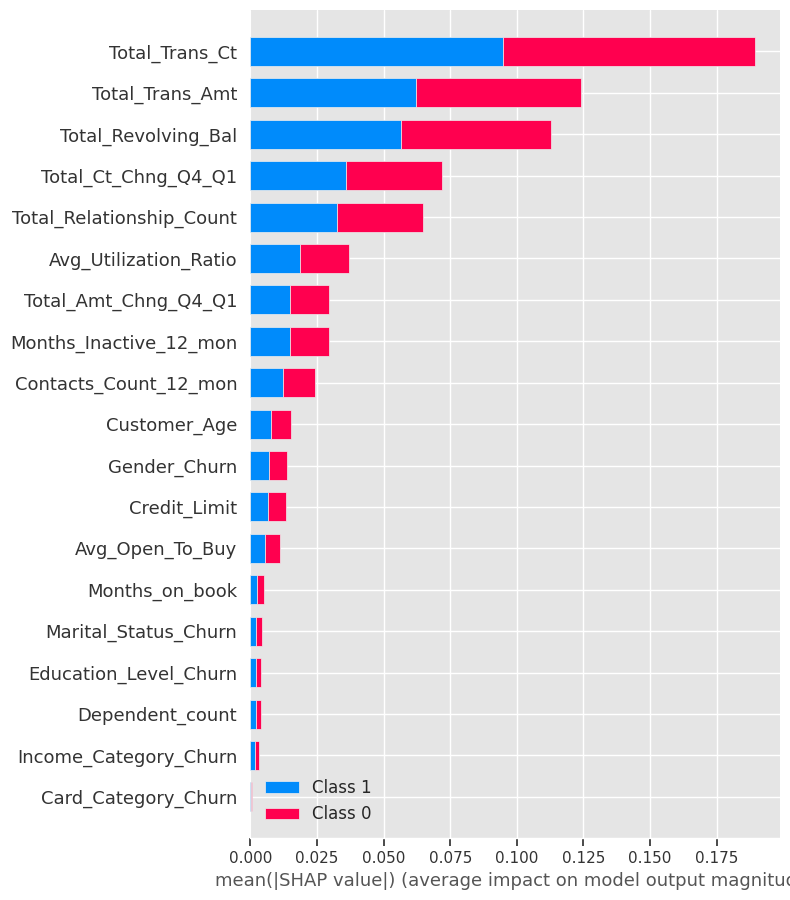

In [33]:
explainer = shap.TreeExplainer(cv_rfc.best_estimator_)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [44]:
shap.plots.waterfall(explainer)

AttributeError: 'Tree' object has no attribute 'base_values'

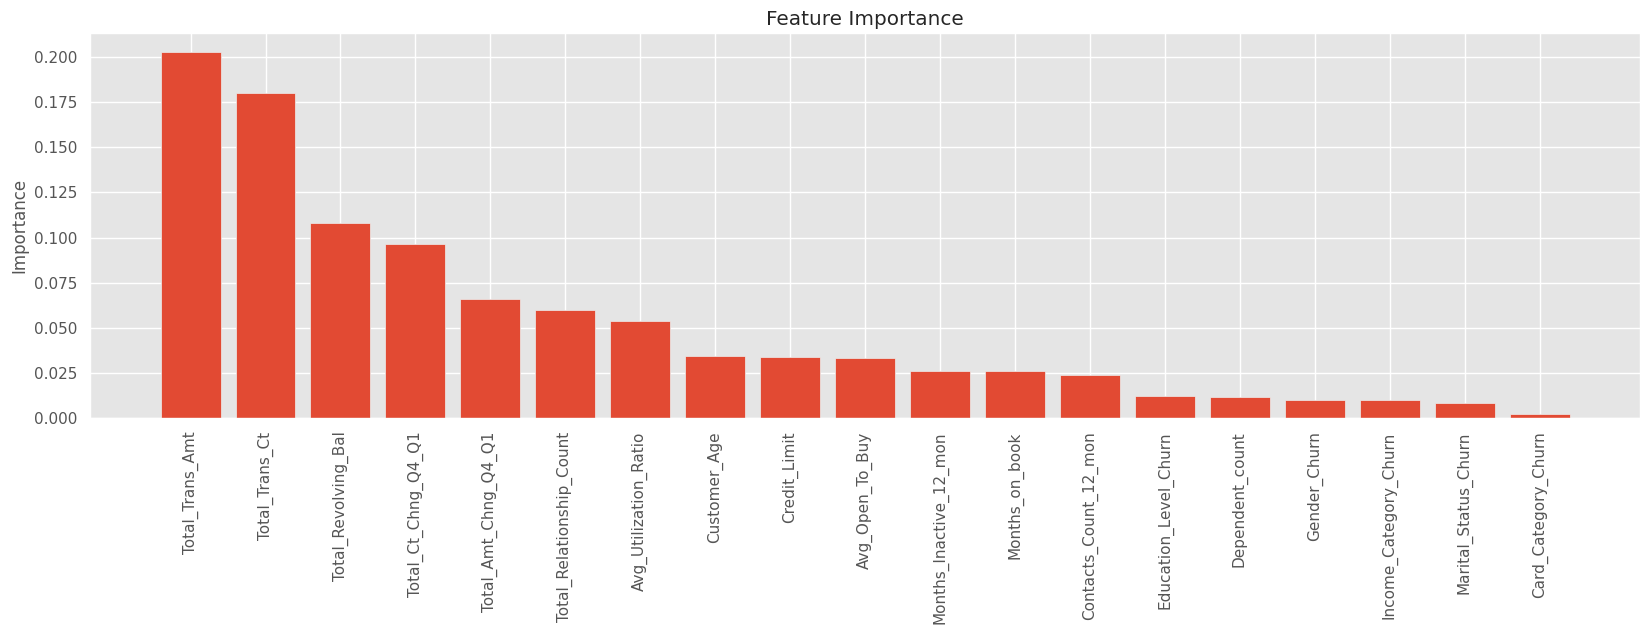

In [34]:
# Calculate feature importances
importances = cv_rfc.best_estimator_.feature_importances_
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X.columns[i] for i in indices]

# Create plot
plt.figure(figsize=(20,5))

# Create plot title
plt.title("Feature Importance")
plt.ylabel('Importance')

# Add bars
plt.bar(range(X.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X.shape[1]), names, rotation=90);

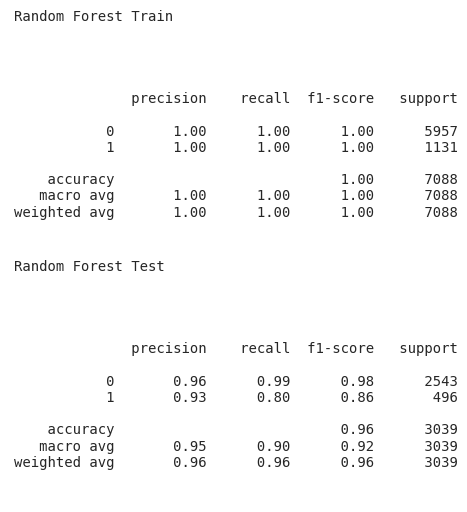

In [35]:
plt.rc('figure', figsize=(5, 5))
#plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 12}) old approach
plt.text(0.01, 1.25, str('Random Forest Train'), {'fontsize': 10}, fontproperties = 'monospace')
plt.text(0.01, 0.05, str(classification_report(y_test, y_test_preds_rf)), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.text(0.01, 0.6, str('Random Forest Test'), {'fontsize': 10}, fontproperties = 'monospace')
plt.text(0.01, 0.7, str(classification_report(y_train, y_train_preds_rf)), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off');


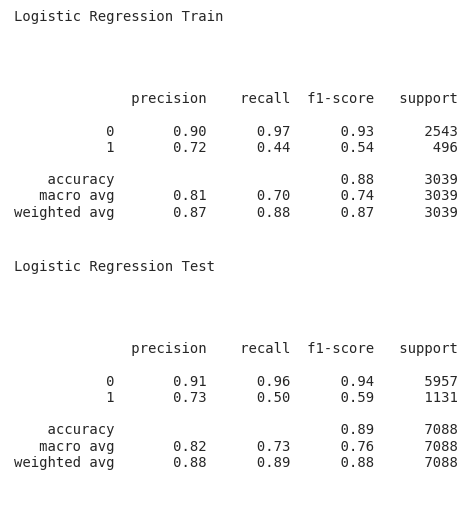

In [36]:
plt.rc('figure', figsize=(5, 5))
plt.text(0.01, 1.25, str('Logistic Regression Train'), {'fontsize': 10}, fontproperties = 'monospace')
plt.text(0.01, 0.05, str(classification_report(y_train, y_train_preds_lr)), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.text(0.01, 0.6, str('Logistic Regression Test'), {'fontsize': 10}, fontproperties = 'monospace')
plt.text(0.01, 0.7, str(classification_report(y_test, y_test_preds_lr)), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off');